# 1. Imports

In [1]:
import pandas as pd
import numpy as np
from ast import literal_eval as leval
import seaborn as sns
from tqdm.auto import tqdm
tqdm.pandas()
from matplotlib import pyplot as plt

def get_outliers(series):
    q1 = series.quantile(0.25)
    q3 = series.quantile(0.75)
    iqr = q3-q1 #Interquartile range
    fence_low  = q1-1.5*iqr
    fence_high = q3+1.5*iqr
    outliers = series[(series < fence_low) | (series > fence_high)]
    return outliers

from emoji import UNICODE_EMOJI

def is_emoji(s):
    flags = re.findall(u'[\U0001F1E6-\U0001F1FF]', s)
    if flags:
        return True
    return s in UNICODE_EMOJI

# 2. Get test dataset

In [2]:
reference_text_df = pd.read_csv('text_extraction/reference_html_as_sentences_df.csv')

claim_data_df = pd.read_csv('text_extraction/text_reference_claims_df.csv')

## 2.1. References

In here we have the information about the references, including the reference ids and the text/sentences extracted.

In [3]:
reference_text_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 676 entries, 0 to 675
Data columns (total 20 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   reference_id           676 non-null    object 
 1   reference_property_id  676 non-null    object 
 2   reference_datatype     676 non-null    object 
 3   url                    676 non-null    object 
 4   netloc                 676 non-null    object 
 5   netloc_agg             676 non-null    object 
 6   error_msg              676 non-null    object 
 7   code                   676 non-null    int64  
 8   content-type           676 non-null    object 
 9   final_url              676 non-null    object 
 10  reason                 662 non-null    object 
 11  language_crawl         676 non-null    object 
 12  language_crawl_score   676 non-null    float64
 13  sampling_weight_vb     676 non-null    object 
 14  sampling_weight        676 non-null    float64
 15  html  

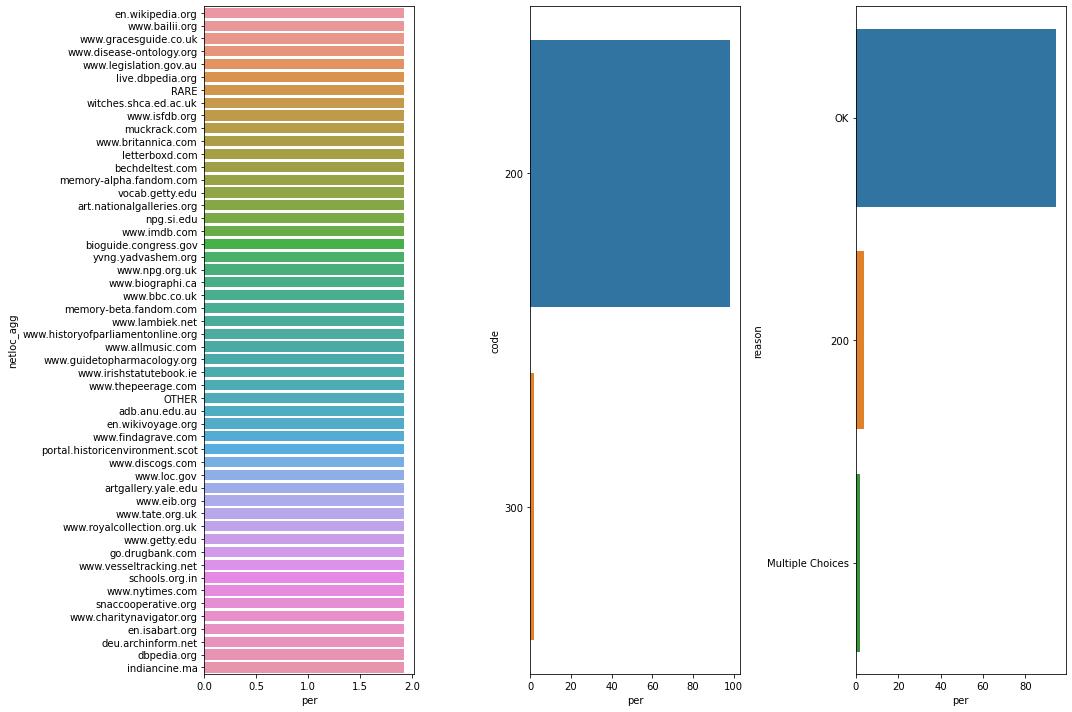

In [4]:
def check_column_dist(df, col):
    counts = df[col].value_counts().reset_index()
    counts.columns = [col, 'counts']
    counts['per'] = 100*counts['counts']/counts['counts'].sum()
    counts[col] = counts[col].astype(str)
    return counts

# Netlocs are equaly spread
# codes are all good
# reasons are good
fig, ax = plt.subplots(1,3,figsize=(15,10))
sns.barplot(data=check_column_dist(reference_text_df, 'netloc_agg'), x='per', y='netloc_agg', ax=ax[0])
sns.barplot(data=check_column_dist(reference_text_df, 'code'), x='per', y='code', ax=ax[1])
sns.barplot(data=check_column_dist(reference_text_df, 'reason'), x='per', y='reason', ax=ax[2])
plt.tight_layout()
plt.show()

## 2.2. Claims

This has all the claim data, including labels, aliases, descriptions, and language IDs.

In [5]:
claim_data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1572 entries, 0 to 1571
Data columns (total 25 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   reference_id        1572 non-null   object
 1   entity_id           1572 non-null   object
 2   claim_id            1572 non-null   object
 3   rank                1572 non-null   object
 4   property_id         1572 non-null   object
 5   datatype            1572 non-null   object
 6   datavalue           1572 non-null   object
 7   entity_label        1572 non-null   object
 8   entity_label_lan    1572 non-null   object
 9   property_label      1572 non-null   object
 10  property_label_lan  1572 non-null   object
 11  entity_alias        1572 non-null   object
 12  entity_alias_lan    1572 non-null   object
 13  property_alias      1572 non-null   object
 14  property_alias_lan  1572 non-null   object
 15  entity_desc         1572 non-null   object
 16  entity_desc_lan     1572

In [6]:
print('Total counts:')
print(f'{claim_data_df.claim_id.unique().shape[0]} unique claims')
print(f'{claim_data_df.reference_id.unique().shape[0]} unique references')

Total counts:
1571 unique claims
676 unique references


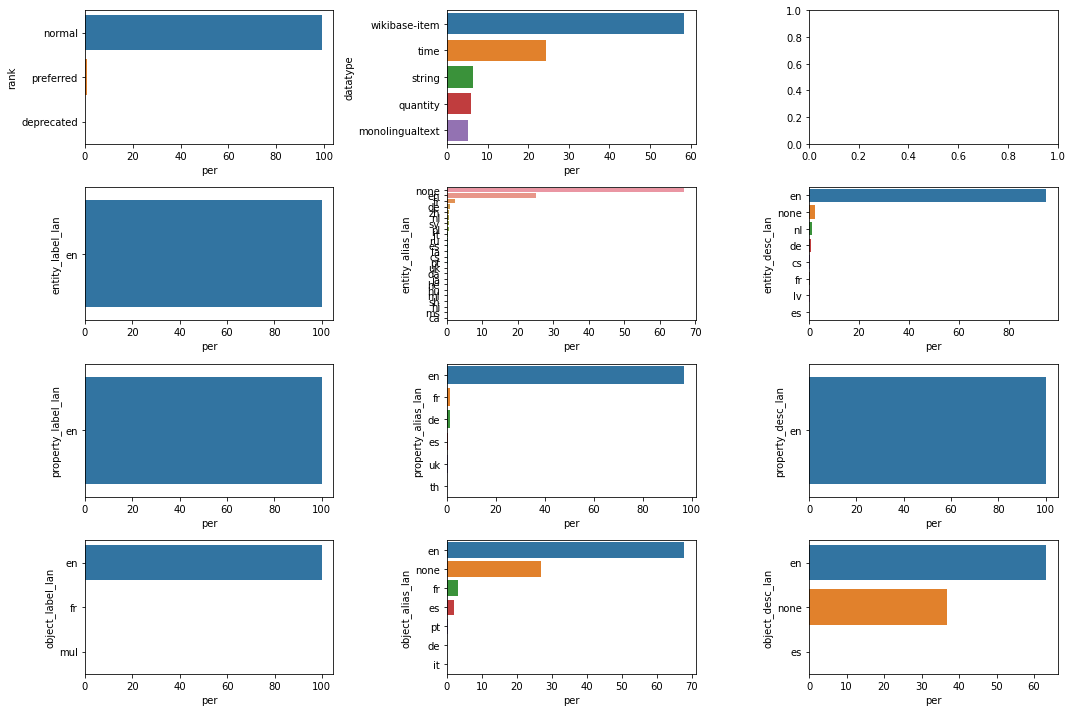

In [81]:
# Considerable amount of aliases for entities, LOTS for properties, reasonable for objects.
# We can use this to generate multiple verbalisations based on aliases.
fig, ax = plt.subplots(4,3,figsize=(15,10))
sns.barplot(data=check_column_dist(claim_data_df, 'rank'), x='per', y='rank', ax=ax[0][0])
sns.barplot(data=check_column_dist(claim_data_df, 'datatype'), x='per', y='datatype', ax=ax[0][1])
#sns.barplot(data=check_column_dist(claim_data_df, 'entity_label_lan'), x='per', y='entity_label_lan', ax=ax[0][2])
sns.barplot(data=check_column_dist(claim_data_df, 'entity_label_lan'), x='per', y='entity_label_lan', ax=ax[1][0])
sns.barplot(data=check_column_dist(claim_data_df, 'entity_alias_lan'), x='per', y='entity_alias_lan', ax=ax[1][1])
sns.barplot(data=check_column_dist(claim_data_df, 'entity_desc_lan'), x='per', y='entity_desc_lan', ax=ax[1][2])
sns.barplot(data=check_column_dist(claim_data_df, 'property_label_lan'), x='per', y='property_label_lan', ax=ax[2][0])
sns.barplot(data=check_column_dist(claim_data_df, 'property_alias_lan'), x='per', y='property_alias_lan', ax=ax[2][1])
sns.barplot(data=check_column_dist(claim_data_df, 'property_desc_lan'), x='per', y='property_desc_lan', ax=ax[2][2])
sns.barplot(data=check_column_dist(claim_data_df, 'object_label_lan'), x='per', y='object_label_lan', ax=ax[3][0])
sns.barplot(data=check_column_dist(claim_data_df, 'object_alias_lan'), x='per', y='object_alias_lan', ax=ax[3][1])
sns.barplot(data=check_column_dist(claim_data_df, 'object_desc_lan'), x='per', y='object_desc_lan', ax=ax[3][2])
plt.tight_layout()
plt.show()

In [134]:
claim_data_df.entity_alias.apply(lambda x : len(leval(x)) if x != 'no-alias' else 0)

0       2
1       1
2       1
3       1
4       1
       ..
1567    0
1568    0
1569    0
1570    0
1571    0
Name: entity_alias, Length: 1572, dtype: int64

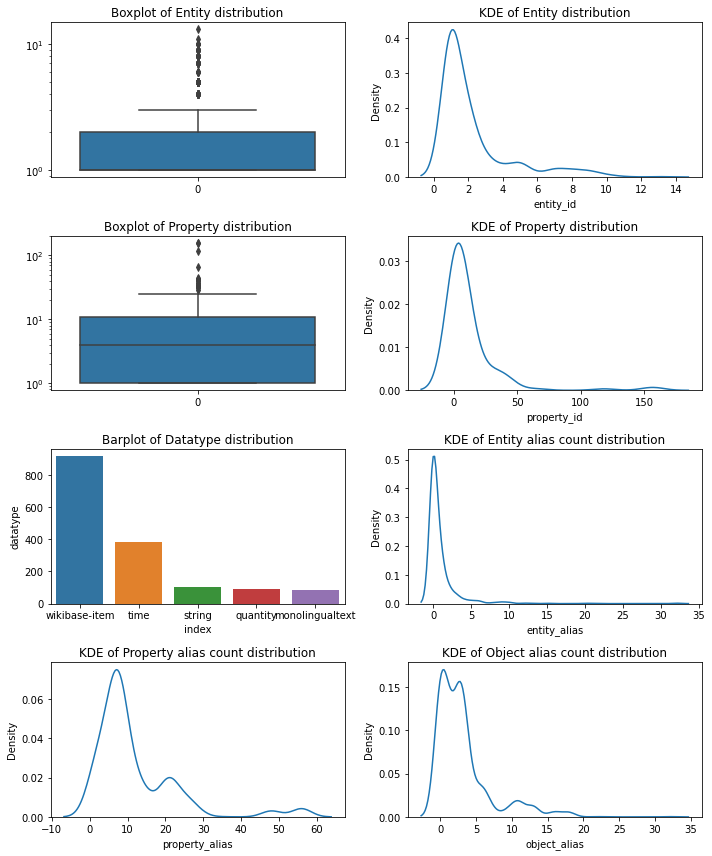

In [139]:
# Distribution of entities and properties involved in the claim data

fig, ax = plt.subplots(4,2,figsize=(10,12))

ax[0][0].set_yscale('log')
entity_count = claim_data_df.entity_id.value_counts()
ax[0][0].set_title('Boxplot of Entity distribution')
sns.boxplot(data = entity_count, ax=ax[0][0])
ax[0][1].set_title('KDE of Entity distribution')
sns.kdeplot(data = entity_count, ax=ax[0][1])

ax[1][0].set_yscale('log')
property_count = claim_data_df.property_id.value_counts()
ax[1][0].set_title('Boxplot of Property distribution')
sns.boxplot(data = property_count, ax=ax[1][0])
ax[1][1].set_title('KDE of Property distribution')
sns.kdeplot(data = property_count, ax=ax[1][1])

datatype_count = claim_data_df.datatype.value_counts().reset_index()
ax[2][0].set_title('Barplot of Datatype distribution')
sns.barplot(data = datatype_count, ax=ax[2][0], x='index', y='datatype')

entity_alias_count = claim_data_df.entity_alias.apply(lambda x : len(leval(x)) if x != 'no-alias' else 0)
ax[2][1].set_title('KDE of Entity alias count distribution')
sns.kdeplot(data = entity_alias_count, ax=ax[2][1])

entity_alias_count = claim_data_df.property_alias.apply(lambda x : len(leval(x)) if x != 'no-alias' else 0)
ax[3][0].set_title('KDE of Property alias count distribution')
sns.kdeplot(data = entity_alias_count, ax=ax[3][0])

entity_alias_count = claim_data_df.object_alias.apply(lambda x : len(leval(x)) if x != 'no-alias' else 0)
ax[3][1].set_title('KDE of Object alias count distribution')
sns.kdeplot(data = entity_alias_count, ax=ax[3][1])

plt.tight_layout()
plt.show()

# We can see that entities and properties are somewhat fairly spread, with most within a lesser volume and a few outliers.
# Datatype has an OK distribution, nothing wrong there for this analysis.
# KDE of alias counts for ent, prop, and obj show most cases on low count and a few outliers.

# 3. Verbalisation

In [ ]:
from verbalisation import verbalisation_module

# If updating the module
#from importlib import reload
#reload(verbalisation_module)

verb_module = verbalisation_module.VerbModule()

CUDA NOT AVAILABLE
Graph2Text hparams are: Namespace(logger=True, checkpoint_callback=True, early_stop_callback=False, default_root_dir=None, gradient_clip_val=0, process_position=0, num_nodes=1, num_processes=1, gpus=1, auto_select_gpus=False, log_gpu_memory=None, progress_bar_refresh_rate=1, overfit_batches=0.0, track_grad_norm=-1, check_val_every_n_epoch=1, fast_dev_run=False, accumulate_grad_batches=1, max_epochs=100, min_epochs=1, max_steps=None, min_steps=None, limit_train_batches=1.0, limit_val_batches=1.0, limit_test_batches=1.0, val_check_interval=1.0, log_save_interval=100, row_log_interval=50, distributed_backend=None, sync_batchnorm=False, precision=32, weights_summary='top', weights_save_path=None, num_sanity_val_steps=2, truncated_bptt_steps=None, resume_from_checkpoint=None, profiler=None, benchmark=False, deterministic=False, reload_dataloaders_every_epoch=False, auto_lr_find=False, replace_sampler_ddp=True, terminate_on_nan=False, auto_scale_batch_size=False, prepare_d

We have added 3 tokens


In [ ]:
verbs = verb_module.verbalise('translate Graph to English: <H> World Trade Center <R> height <T> 200 meter <H> World Trade Center <R> is a <T> tower')
#print(verbs)
assert verbs == 'The World Trade Center is a tower with a height of 200 meters.'

verbs = verb_module.verbalise({'subject': 'World Trade Center','predicate': 'height','object' : '200 meter'})
#print(verbs)
assert verbs == 'The height of the World Trade Center is 200 meters.'

verbs = verb_module.verbalise([[
        {'subject': 'World Trade Center','predicate': 'is a','object' : 'tower'},
        {'subject': 'World Trade Center','predicate': 'height','object' : '200 meter'}
]])
#print(verbs)
assert verbs == 'The World Trade Center is a tower with a height of 200 meters.'

verbs = verb_module.verbalise([
    {'subject': 'World Trade Center','predicate': 'is a','object' : 'tower'},
    {'subject': 'World Trade Center','predicate': 'height','object' : '200 meter'}
])
#print(verbs)
assert verbs == [
    'The World Trade Center is a tower.',
    'The height of the World Trade Center is 200 meters.'
]

verbs = verb_module.verbalise({'subject': 'Cuhppulčohkka','predicate': 'instance of','object' : 'native label'})
#print(verbs)
assert verbs == 'Cuhppul<unk>ohkka is an instance of a native label.'

verb_module.add_label_to_unk_replacer('Cuhppulčohkka')
sent = verb_module.replace_unks_on_sentence('Cuhppul<unk>ohkka is a native label.', empty_after=True)
#print(verbs)
assert sent == 'Cuhppulčohkka is a native label.'

verb_module.add_label_to_unk_replacer('Cuhppulohkkač')
sent = verb_module.replace_unks_on_sentence('Cuhppulohkka<unk> is a native label.', empty_after=True)
#print(verbs)
assert sent == 'Cuhppulohkkač is a native label.'


verb_module.add_label_to_unk_replacer('🇬🇧')
sent = verb_module.replace_unks_on_sentence('The Value Added Tax Order 2016 applies to jurisdiction of <unk>.', empty_after=True)
#print(verbs)
assert sent == 'The Value Added Tax Order 2016 applies to jurisdiction of 🇬🇧.'

In [13]:
try:
    verbalised_claims_df = pd.read_csv('verbalisation/verbalised_claims_df.csv')
except Exception:
    verbalised_claims_df = None

In [ ]:
import json
import time

BATCH_SIZE = 16
verbalised_claims_this_batch = []

claim_data_to_keep = [
    'reference_id', 'entity_id', 'claim_id', 'rank', 'property_id', 'datatype',
    'entity_label', 'entity_desc', 'property_label', 'property_desc', 'object_label', 'object_desc'
] # also add entity_label_is_alias, same for property and object

if verbalised_claims_df is not None and not verbalised_claims_df.empty:
    verbalised_claims = json.loads(
        verbalised_claims_df[verbalised_claims_df['verbalisation'] != 'NO_VERBALISATION'].to_json(orient="records")
    )
else:
    verbalised_claims = []

print(len(verbalised_claims))

with open('verbalisation.log','w+',encoding='utf-8') as f:

    for i, row in tqdm(claim_data_df.iterrows(), total=claim_data_df.shape[0]):
    
        try:

            subjects = [row['entity_label']] if row['entity_label_lan'] == 'en' else []
            subjects += leval(row['entity_alias']) if row['entity_alias_lan'] == 'en' else []

            for i_s, subject in enumerate(subjects):

                predicates = [row['property_label']] if row['property_label_lan'] == 'en' else []
                predicates += leval(row['property_alias']) if row['property_alias_lan'] == 'en' else []

                for i_p, predicate in enumerate(predicates):

                    objects = [row['object_label']] if row['object_label_lan'] == 'en' else []
                    objects += leval(row['object_alias']) if row['object_alias_lan'] == 'en' else []

                    for i_o, object_ in enumerate(objects):

                        verbalised_claim_entry = {
                            c : row[c] for c in claim_data_to_keep
                        }                        
                        
                        if type(verbalised_claims_df) == pd.core.frame.DataFrame:
                            if not verbalised_claims_df[
                                (verbalised_claims_df['reference_id'] == row['reference_id']) &\
                                (verbalised_claims_df['claim_id'] == row['claim_id']) &\
                                (verbalised_claims_df['entity_label'] == subject) &\
                                (verbalised_claims_df['object_label'] == object_) &\
                                (verbalised_claims_df['property_label'] == predicate)                        
                            ].empty:
                                continue                        
                        #print('nonempty found:','-'.join([subject, predicate, object_]))

                        verbalised_claim_entry.update({
                            'entity_label_is_alias': (i_s != 0),
                            'property_label_is_alias': (i_p != 0),
                            'object_label_is_alias': (i_o != 0),
                            'entity_label': subject,
                            'property_label': predicate,
                            'object_label': object_
                        })
                        
                        is_last =\
                            (i == claim_data_df.shape[0]-1) &\
                            (i_s == len(subjects)-1) &\
                            (i_p == len(predicates)-1) &\
                            (i_o == len(objects)-1)
                            
                        
                        verbalised_claims_this_batch.append(verbalised_claim_entry)
                        if len(verbalised_claims_this_batch) >= BATCH_SIZE or is_last:
                            #print('verbalising...')
                            verbalisation_inputs = [{
                                'subject':e['entity_label'], 'predicate':e['property_label'], 'object':e['object_label']
                            } for e in verbalised_claims_this_batch]

                            try:
                                verbalisations = verb_module.verbalise(verbalisation_inputs)
                                f.write(
                                    f'Verbalising: {[(v["reference_id"], v['claim_id']) for v in verbalised_claims_this_batch]}\n'
                                )
                            except Exception:
                                print('ERROR VERBALISING:', verbalisation_inputs, sep='\n')
                                raise            

                            for i in range(len(verbalised_claims_this_batch)):
                                try:
                                    verb_module.add_label_to_unk_replacer(verbalised_claims_this_batch[i]['entity_label'])
                                    verb_module.add_label_to_unk_replacer(verbalised_claims_this_batch[i]['object_label'])
                                    verbalised_claims_this_batch[i].update({
                                        'verbalisation' : verbalisations[i],
                                        'verbalisation_unks_replaced': verb_module.replace_unks_on_sentence(
                                            verbalisations[i], empty_after=True
                                        )
                                    })
                                except Exception:
                                    print('REPLACING_ERROR on', verbalised_claims_this_batch[i])
                                    verbalised_claims_this_batch[i].update({
                                        'verbalisation' : verbalisations[i],
                                        'verbalisation_unks_replaced': 'REPLACING_ERROR'
                                    })

                            verbalised_claims += verbalised_claims_this_batch
                            verbalised_claims_this_batch = []

        except Exception:
            print(row)
            #pprint(verbalised_claims_this_row)
            raise

# Load 
verbalised_claims_df = pd.DataFrame(verbalised_claims)

0


  0%|          | 0/1572 [00:00<?, ?it/s]

In [257]:
verbalised_claims_df

,reference_id,entity_id,claim_id,reference_claim_id,rank,property_id,datatype,entity_label,entity_desc,property_label,property_desc,object_label,object_desc,entity_label_is_alias,property_label_is_alias,object_label_is_alias,verbalisation,verbalisation_unks_replaced
0,390d6c6e68a32e11f8d7b0883cda0557db529fe6,Q5512528,Q5512528$81E8AD02-28AF-4AE3-8ACD-047C30B40B01,390d6c6e68a32e11f8d7b0883cda0557db529fe6-Q5512...,normal,P20,wikibase-item,G. V. Raja,sports official,place of death,most specific known (e.g. city instead of coun...,Kullu Valley,"valley in Himachal Pradesh, India",False,False,False,G V Raja died in Kullu Valley.,G V Raja died in Kullu Valley.
1,390d6c6e68a32e11f8d7b0883cda0557db529fe6,Q5512528,Q5512528$81E8AD02-28AF-4AE3-8ACD-047C30B40B01,390d6c6e68a32e11f8d7b0883cda0557db529fe6-Q5512...,normal,P20,wikibase-item,G. V. Raja,sports official,deathplace,most specific known (e.g. city instead of coun...,Kullu Valley,"valley in Himachal Pradesh, India",False,True,False,G V Raja died in Kullu Valley.,G V Raja died in Kullu Valley.
2,390d6c6e68a32e11f8d7b0883cda0557db529fe6,Q5512528,Q5512528$81E8AD02-28AF-4AE3-8ACD-047C30B40B01,390d6c6e68a32e11f8d7b0883cda0557db529fe6-Q5512...,normal,P20,wikibase-item,G. V. Raja,sports official,died in,most specific known (e.g. city instead of coun...,Kullu Valley,"valley in Himachal Pradesh, India",False,True,False,G V Raja died in Kullu Valley.,G V Raja died in Kullu Valley.
3,390d6c6e68a32e11f8d7b0883cda0557db529fe6,Q5512528,Q5512528$81E8AD02-28AF-4AE3-8ACD-047C30B40B01,390d6c6e68a32e11f8d7b0883cda0557db529fe6-Q5512...,normal,P20,wikibase-item,G. V. Raja,sports official,death place,most specific known (e.g. city instead of coun...,Kullu Valley,"valley in Himachal Pradesh, India",False,True,False,G V Raja died in Kullu Valley.,G V Raja died in Kullu Valley.
4,390d6c6e68a32e11f8d7b0883cda0557db529fe6,Q5512528,Q5512528$81E8AD02-28AF-4AE3-8ACD-047C30B40B01,390d6c6e68a32e11f8d7b0883cda0557db529fe6-Q5512...,normal,P20,wikibase-item,G. V. Raja,sports official,POD,most specific known (e.g. city instead of coun...,Kullu Valley,"valley in Himachal Pradesh, India",False,True,False,G V Raja is a member of the POD in Kullu Valley.,G V Raja is a member of the POD in Kullu Valley.
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135039,6e6204011de4f4176362a6f4067486a94fc6ac3e,Q58435606,Q58435606$82576BDF-9365-462C-B1F8-A6FF6B8FBE9D,6e6204011de4f4176362a6f4067486a94fc6ac3e-Q5843...,normal,P462,wikibase-item,Jai Bhawani,1928 film,with the color,color of subject,B&W,monochrome form in visual arts,False,True,True,Jai Bhawani has the color B&W.,Jai Bhawani has the color B&W.
135040,6e6204011de4f4176362a6f4067486a94fc6ac3e,Q58435606,Q58435606$82576BDF-9365-462C-B1F8-A6FF6B8FBE9D,6e6204011de4f4176362a6f4067486a94fc6ac3e-Q5843...,normal,P462,wikibase-item,Jai Bhawani,1928 film,with the color,color of subject,colorless cinema,monochrome form in visual arts,False,True,True,Jai Bhawani is a colorless cinema.,Jai Bhawani is a colorless cinema.
135041,6e6204011de4f4176362a6f4067486a94fc6ac3e,Q58435606,Q58435606$82576BDF-9365-462C-B1F8-A6FF6B8FBE9D,6e6204011de4f4176362a6f4067486a94fc6ac3e-Q5843...,normal,P462,wikibase-item,Jai Bhawani,1928 film,with the color,color of subject,black-and-white cinema,monochrome form in visual arts,False,True,True,Jai Bhawani is a black-and-white film.,Jai Bhawani is a black-and-white film.
135042,6e6204011de4f4176362a6f4067486a94fc6ac3e,Q58435606,Q58435606$82576BDF-9365-462C-B1F8-A6FF6B8FBE9D,6e6204011de4f4176362a6f4067486a94fc6ac3e-Q5843...,normal,P462,wikibase-item,Jai Bhawani,1928 film,with the color,color of subject,black and white film,monochrome form in visual arts,False,True,True,Jai Bhawani is a black and white film.,Jai Bhawani is a black and white film.


In [11]:
# Checking if every combination of ENGLISH label+alias for (s,p,o) tuples has been covered
# NO OUTPUTS = ALL OK

claims_list = verbalised_claims_df.claim_id.unique().tolist()
for c_id in claims_list:
    row = claim_data_df[claim_data_df['claim_id'] == c_id]
    matching_claims = row.shape[0]
    verbalised_n_rows = verbalised_claims_df[verbalised_claims_df.claim_id == c_id].shape[0]
    
    verbalised_n_rows_target =\
        ((len(leval(row['entity_alias'].values[0])) if row['entity_alias_lan'].iloc[0] == 'en' else 0) +1) * \
        ((len(leval(row['property_alias'].values[0])) if row['property_alias_lan'].iloc[0] == 'en' else 0) +1) * \
        ((len(leval(row['object_alias'].values[0])) if row['object_alias_lan'].iloc[0] == 'en' else 0) +1)
    
    try:
        assert verbalised_n_rows == verbalised_n_rows_target * matching_claims
    except AssertionError:
        print('Match Error:',c_id)
        print( row.index.values,
            verbalised_n_rows, 'out of', verbalised_n_rows_target * matching_claims,
            f'{verbalised_n_rows_target * matching_claims - verbalised_n_rows} to go')

In [99]:
verbalised_claims_df.to_csv('verbalisation/verbalised_claims_df.csv', index=None)

## Verbalised data analysis

In [6]:
verbalised_claims_df = pd.read_csv('verbalisation/verbalised_claims_df.csv')
verbalised_claims_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135044 entries, 0 to 135043
Data columns (total 18 columns):
 #   Column                       Non-Null Count   Dtype 
---  ------                       --------------   ----- 
 0   reference_id                 135044 non-null  object
 1   entity_id                    135044 non-null  object
 2   claim_id                     135044 non-null  object
 3   reference_claim_id           135044 non-null  object
 4   rank                         135044 non-null  object
 5   property_id                  135044 non-null  object
 6   datatype                     135044 non-null  object
 7   entity_label                 135044 non-null  object
 8   entity_desc                  135044 non-null  object
 9   property_label               135044 non-null  object
 10  property_desc                135044 non-null  object
 11  object_label                 135044 non-null  object
 12  object_desc                  135044 non-null  object
 13  entity_label_i

In [7]:
print('Total verbalised counts:')
print(f'{verbalised_claims_df.claim_id.unique().shape[0]} unique claims')
print(f'{verbalised_claims_df.reference_id.unique().shape[0]} unique references')

Total verbalised counts:
1569 unique claims
676 unique references


In [8]:
# 
n_unk_replacements = verbalised_claims_df[verbalised_claims_df['verbalisation'].apply(lambda x : '<unk>' in x)].shape[0]
print(
    f"Unk replacement was needed in {n_unk_replacements} ({100*n_unk_replacements/verbalised_claims_df.shape[0]}%) of verbalisations"
)

n_unk_replacements_solved = verbalised_claims_df[verbalised_claims_df['verbalisation_unks_replaced'].apply(lambda x : '<unk>' in x)].shape[0]
print(
    f"Unk replacement was NOT solved in {n_unk_replacements_solved} ({100*n_unk_replacements_solved/n_unk_replacements}%) of cases"
)

Unk replacement was needed in 3489 (2.583602381446047%) of verbalisations
Unk replacement was NOT solved in 209 (5.990255087417598%) of cases


In [9]:
# ATTENTION: Quantity aliases are wrong, they only have the alias of the metric, not the amount.
# It would be good, WHEN USING ALIASES-BASED VERBALISATIONS, to correct those
verbalised_claims_df[verbalised_claims_df['datatype'] == 'quantity'].head()

,reference_id,entity_id,claim_id,reference_claim_id,rank,property_id,datatype,entity_label,entity_desc,property_label,property_desc,object_label,object_desc,entity_label_is_alias,property_label_is_alias,object_label_is_alias,verbalisation,verbalisation_unks_replaced
102,9d3888688b4b18f5fee86aa6f9817b6d49cc2587,Q875232,Q875232$2D10C898-1A44-4F06-9B72-473F20BA1DCD,9d3888688b4b18f5fee86aa6f9817b6d49cc2587-Q8752...,normal,P2043,quantity,Alabama State Route 145,highway in Alabama,length,measured dimension of an object,26.996 mile,unit of length,False,False,False,The Alabama State Route 145 is 26.996 miles long.,The Alabama State Route 145 is 26.996 miles long.
103,9d3888688b4b18f5fee86aa6f9817b6d49cc2587,Q875232,Q875232$2D10C898-1A44-4F06-9B72-473F20BA1DCD,9d3888688b4b18f5fee86aa6f9817b6d49cc2587-Q8752...,normal,P2043,quantity,Alabama State Route 145,highway in Alabama,length,measured dimension of an object,mi,unit of length,False,False,True,Alabama State Route 145 is 145 mi long.,Alabama State Route 145 is 145 mi long.
104,9d3888688b4b18f5fee86aa6f9817b6d49cc2587,Q875232,Q875232$2D10C898-1A44-4F06-9B72-473F20BA1DCD,9d3888688b4b18f5fee86aa6f9817b6d49cc2587-Q8752...,normal,P2043,quantity,Alabama State Route 145,highway in Alabama,length,measured dimension of an object,m,unit of length,False,False,True,The length of Alabama State Route 145 is m.,The length of Alabama State Route 145 is m.
105,9d3888688b4b18f5fee86aa6f9817b6d49cc2587,Q875232,Q875232$2D10C898-1A44-4F06-9B72-473F20BA1DCD,9d3888688b4b18f5fee86aa6f9817b6d49cc2587-Q8752...,normal,P2043,quantity,Alabama State Route 145,highway in Alabama,length,measured dimension of an object,miles,unit of length,False,False,True,Alabama State Route 145 has a length of 145 mi...,Alabama State Route 145 has a length of 145 mi...
106,9d3888688b4b18f5fee86aa6f9817b6d49cc2587,Q875232,Q875232$2D10C898-1A44-4F06-9B72-473F20BA1DCD,9d3888688b4b18f5fee86aa6f9817b6d49cc2587-Q8752...,normal,P2043,quantity,Alabama State Route 145,highway in Alabama,distance,measured dimension of an object,26.996 mile,unit of length,False,True,False,The Alabama State Route 145 is 26.996 miles.,The Alabama State Route 145 is 26.996 miles.


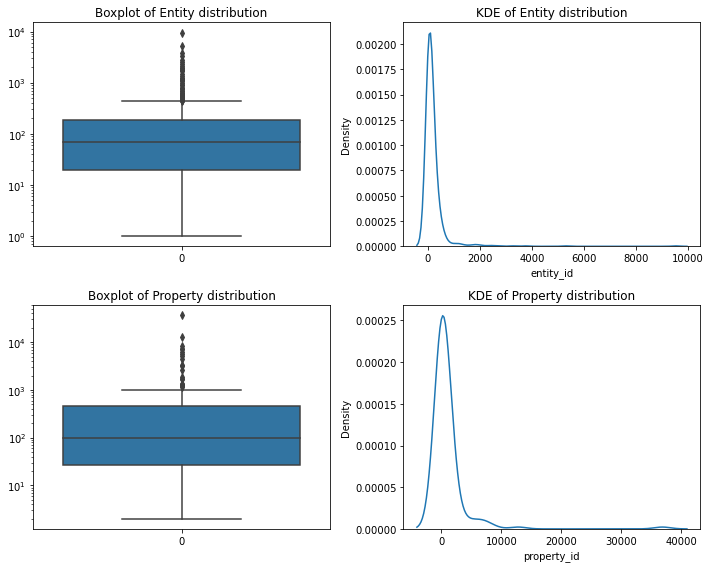

In [10]:
# Distribution of entities and properties involved in the verbalisations

fig, ax = plt.subplots(2,2,figsize=(10,8))

ax[0][0].set_yscale('log')
entity_count = verbalised_claims_df.entity_id.value_counts()
ax[0][0].set_title('Boxplot of Entity distribution')
sns.boxplot(data = entity_count, ax=ax[0][0])
ax[0][1].set_title('KDE of Entity distribution')
sns.kdeplot(data = entity_count, ax=ax[0][1])

ax[1][0].set_yscale('log')
property_count = verbalised_claims_df.property_id.value_counts()
ax[1][0].set_title('Boxplot of Property distribution')
sns.boxplot(data = property_count, ax=ax[1][0])
ax[1][1].set_title('KDE of Property distribution')
sns.kdeplot(data = property_count, ax=ax[1][1])

plt.tight_layout()
plt.show()

# Half of both entities and properties show up between 50 and 200/500 times,
# the majority being between 1 and 1000. A few outliers are beyond that.

# Entities/Properties that are over-represented here are due to having too many aliases.

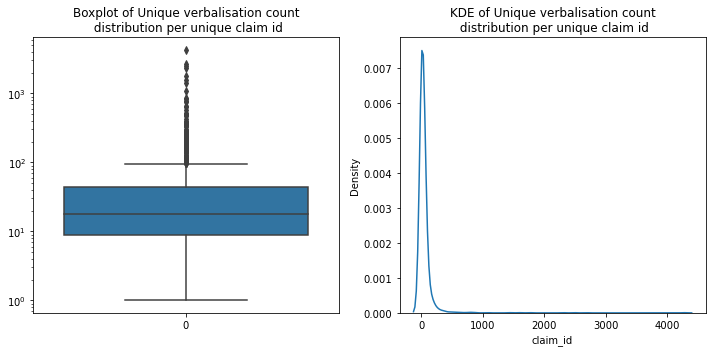

,claim_id,count
0,Q413762$C5D101E9-E57F-4EA3-8D7B-C6C08BEEF3E3,4267
1,Q411646$985DD31A-14E7-4BD1-A920-C57D7591F21D,2670
2,q413762$9C2AD3C8-99A3-49F6-A2DA-67EA8FD7680A,2482
3,Q683861$C89C357A-46F6-4407-A921-9D3E8869513D,2296
4,Q154869$F69C6AB9-0A67-41CF-BBE9-1A12E1EB744B,1759
...,...,...
146,Q100328935$ca971e29-ea7a-4c2b-9df6-b6f79c662966,98
147,Q21454473$FA1B3078-4975-4EC2-A7A0-9A7CFD939342,98
148,Q58480336$53D2AD06-4343-4CB0-9332-3CA0D1AC2A33,98
149,Q59279451$E2B1DA8D-6397-4FE0-874C-7F642DAA671D,97


In [11]:
unique_verbalisation_counts = verbalised_claims_df[['claim_id', 'verbalisation_unks_replaced']].\
    drop_duplicates().claim_id.value_counts()

# Distribution of entities and properties involved in the verbalisations

fig, ax = plt.subplots(1,2,figsize=(10,5))

ax[0].set_yscale('log')
ax[0].set_title('Boxplot of Unique verbalisation count\n distribution per unique claim id')
sns.boxplot(data = unique_verbalisation_counts, ax=ax[0])
ax[1].set_title('KDE of Unique verbalisation count\n distribution per unique claim id')
sns.kdeplot(data = unique_verbalisation_counts, ax=ax[1])

plt.tight_layout()
plt.show()

# This shows the majority of claims have up to 100 unique verbalisations due to aliases, with some having way more.
# The biggest one, for instance, has 33 subject aliases, 22 predicate aliases, and 8 object aliases

get_outliers(unique_verbalisation_counts).reset_index().rename({'index':'claim_id','claim_id':'count'}, axis=1)

# 4. Sentence Selection

Due to the HUGE amounts of verbalisations per unique claim, we will now only look at the verbalisations with **MAIN labels**.

As next steps, we **CAN**:
1. Select main label verbalisations + 10 others at random from the whole set **(DOING THIS NOW)**
2. Select main label verbalisations + 10 others at random given that they (subj and obj) *appear on the document*
    1. Quantity-datatupe verbalisations **have an error in the object alias**, pay attention to that.
3. Select main label verbalisations + 10 others based on some scoring function

Here, we **WILL**:
1. Combine the 1570 verbalised claims with their respective reference contents (as sentences).
2. Then, we will calculate a relevance score for each sentence, and keep only the (up-to) 5 best positive scores.

In [12]:
verbalised_claims_df_main_labels = verbalised_claims_df[(~verbalised_claims_df['entity_label_is_alias'] &\
    ~verbalised_claims_df['property_label_is_alias'] &\
    ~verbalised_claims_df['object_label_is_alias'])].reset_index(drop=True)
# might be more than unique number of claims as a claim might be associated to multiple references, and here we
# do not count unique claims

# might also be less, as some claims do not have english labels nor aliases on objects

# Remove redundant columns and unnecessary columns for the merging with reference contents data
verbalised_claims_df_main_labels = verbalised_claims_df_main_labels[[
    'reference_id', 'claim_id', 'verbalisation_unks_replaced'
]]

# Take only the data relevant for joining with the verbalisation data and calculating sentence relevance scores

# The sampling weights CAN ONLY BE USED to average-out any score or quantifiable property that is assigned to EACH REFERENCE,
# such as: percentage of claims actually supported by the reference out of all claims linked to it according
# to pipeline results

reference_text_df_for_sentence_selection_join = reference_text_df[[
    'reference_id', 'final_url', 'nlp_sentences', 'nlp_sentences_slide_2'
]]

sentence_relevance_df = pd.merge(
    verbalised_claims_df_main_labels,
    reference_text_df_for_sentence_selection_join,
    how='left',
    on='reference_id'
)

sentence_relevance_df['nlp_sentences'] = sentence_relevance_df['nlp_sentences'].apply(leval)
sentence_relevance_df['nlp_sentences_slide_2'] = sentence_relevance_df['nlp_sentences_slide_2'].apply(leval)

In [13]:
sentence_relevance_df

,reference_id,claim_id,verbalisation_unks_replaced,final_url,nlp_sentences,nlp_sentences_slide_2
0,390d6c6e68a32e11f8d7b0883cda0557db529fe6,Q5512528$81E8AD02-28AF-4AE3-8ACD-047C30B40B01,G V Raja died in Kullu Valley.,https://en.wikipedia.org/w/index.php?title=G._...,"[G. V. Raja., From Wikipedia, the free encyclo...","[G. V. Raja. From Wikipedia, the free encyclop..."
1,49b9aec8e10815611ff0379a34d5fd7c3830566e,Q12149940$C9FE5F0C-78FD-4ECE-B1C2-16A763B8ED4E,Sebastian Sabol's religion is the Greek cathol...,https://en.wikipedia.org/w/index.php?title=Seb...,"[Sebastian Sabol., From Wikipedia, the free en...","[Sebastian Sabol. From Wikipedia, the free enc..."
2,ab3e9ada7246257ffbfb86fa90a54f25e45a704e,Q583556$929DCD2F-3B4A-41B5-89E7-EEC549077834,The Average White Band was formed in Dundee.,https://en.wikipedia.org/w/index.php?title=Ave...,"[Average White Band., From Wikipedia, the free...","[Average White Band. From Wikipedia, the free ..."
3,ab3e9ada7246257ffbfb86fa90a54f25e45a704e,Q583556$2AD75C92-953E-47CB-93A6-D082674F4231,The average white band was started in 1972.,https://en.wikipedia.org/w/index.php?title=Ave...,"[Average White Band., From Wikipedia, the free...","[Average White Band. From Wikipedia, the free ..."
4,76b04346ad57869d9e5ae1007ba8343d708ab6f9,Q7586053$AD344012-A522-4A8A-AF64-16F859E2EA9A,Yutaka Higuchi started work in 1983.,https://en.wikipedia.org/w/index.php?title=Yut...,"[Yutaka Higuchi (musician) From Wikipedia, the...","[Yutaka Higuchi (musician) From Wikipedia, the..."
...,...,...,...,...,...,...
1565,8bb93e520f7ca8208f24078434b8f5f2ba8b520b,Q58484448$DB944078-CA87-4617-B942-5B290F2144ED,Gul Sanobar is an example of a film.,https://indiancine.ma/BKF,[Gul Sanobar (1934) Director: Homi Master; Wri...,[Gul Sanobar (1934) Director: Homi Master; Wri...
1566,8bb93e520f7ca8208f24078434b8f5f2ba8b520b,Q58484448$9611AF89-1BD2-4D49-9CBB-E3EC52C7765D,Gul Sanobar's original language is Hindi.,https://indiancine.ma/BKF,[Gul Sanobar (1934) Director: Homi Master; Wri...,[Gul Sanobar (1934) Director: Homi Master; Wri...
1567,8bb93e520f7ca8208f24078434b8f5f2ba8b520b,Q58484448$E03C8ED8-0593-4D47-B002-6371900A238E,Gul Sanobar is in black and white.,https://indiancine.ma/BKF,[Gul Sanobar (1934) Director: Homi Master; Wri...,[Gul Sanobar (1934) Director: Homi Master; Wri...
1568,6e6204011de4f4176362a6f4067486a94fc6ac3e,Q58435606$474B340F-3E0A-451C-8844-C02092719DD0,Jai Bhawani is a film.,https://indiancine.ma/YI,"[Jai Bhawani (1928) Director: K.P. Bhave., Ind...",[Jai Bhawani (1928) Director: K.P. Bhave. Indi...


In [19]:
from sentence_retrieval import sentence_retrieval_module

# If updating the module
#from importlib import reload
#reload(sentence_retrieval_module)

sr_module = sentence_retrieval_module.SentenceRetrievalModule()

CUDA NOT AVAILABLE


In [41]:
sentence_relevance_df['nlp_sentences_scores'] = None
sentence_relevance_df['nlp_sentences_slide_2_scores'] = None

In [ ]:
BATCH_SIZE = 32

def chunks(l, n):
    n = max(1, n)
    return [l[i:i+n] for i in range(0, len(l), n)]

for i, row in tqdm(sentence_relevance_df.iterrows(), total=sentence_relevance_df.shape[0]):
    
    outputs = []
    for batch in chunks(row['nlp_sentences'], BATCH_SIZE):
        batch_outputs = sr_module.score_sentence_pairs(
            [(row['verbalisation_unks_replaced'], sentence) for sentence in batch]
        )
        outputs += batch_outputs
    
    sentence_relevance_df.loc[i,'nlp_sentences_scores'] = outputs

  0%|          | 0/1570 [00:00<?, ?it/s]

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
